# Unfair Clauses - NLP Project
## [Jakub Rogala](jr428208@hpc.icm.edu.pl), 428208

## Project overwiew
The goal of the exercise is to develop a binary classifier specialiezd in categorizing consumer contracts terms as legal or illegal, based on Polish Office of Competition and Consumer Protection dataset.

### Imports

In [1]:
import os
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True,max_split_size_mb:128"

import importlib
import re
import string
import warnings
import optuna
import transformers
import torch
import gc

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import umap
import unfair_clauses_data_provider
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, accuracy_score, classification_report
from sklearn.model_selection import GridSearchCV, ParameterGrid
from sklearn.pipeline import Pipeline
from transformers import DataCollatorWithPadding, AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments, AutoModelForCausalLM, BitsAndBytesConfig
from tqdm.auto import tqdm

importlib.reload(unfair_clauses_data_provider)

/home/jakub/DevProjects/ICM/NLP/.venv/lib/python3.14/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


<module 'unfair_clauses_data_provider' from '/home/jakub/DevProjects/ICM/NLP/unfair_clauses_data_provider.py'>

## Data
The data used in project was prepared by Polish Office of Competition and Consumer Protection and it is publicly available on [Hugging Face](https://huggingface.co/datasets/laugustyniak/abusive-clauses-pl).

For data updates or a data reset, a part of the implemented data provider is presented below.

This part is required to run only once and is therefore located in a separate code block.

In [2]:
unfair_clauses_data_provider.UnfairClausesDataProvider.download_data("data")

### Data loading
The dataset is pre-split into ```traning```, ```validation (dev)``` and ```test``` sets.

The data is first loaded as a dataset and then converted into a Pandas dataframes.

In [2]:
d_provider = unfair_clauses_data_provider.UnfairClausesDataProvider()

train_ds = d_provider.load_data("train")
train_df = train_ds.to_pandas()

val_ds = d_provider.load_data("val")
val_df = val_ds.to_pandas()

test_ds = d_provider.load_data("test")
test_df = test_ds.to_pandas()

train_df.head()

,text,label,label_name
0,Wszelka korespondencja wysyłana przez Pożyczko...,1,KLAUZULA_ABUZYWNA
1,W przypadku opóźnień Pożyczkobiorcy w spłacie ...,1,KLAUZULA_ABUZYWNA
2,W przypadku opóźnień Pożyczkobiorcy w spłacie ...,1,KLAUZULA_ABUZYWNA
3,Pożyczkobiorca zleca firmie Narodowy Fundusz P...,1,KLAUZULA_ABUZYWNA
4,Od niespłaconej w terminie raty Pożyczkobiorca...,1,KLAUZULA_ABUZYWNA


### Data integrity
The first step is checking the completeness of the loaded data. For this purpose, the number of missing values and empty strings is verified for each set.

In [ ]:
print("=== Train Data ===")
print("Train set size:", len(train_df))
print("Number of missing values: ", train_df['text'].isna().sum())
print("Number of empty clauses: ", (train_df['text'] == '').sum(), "\n")

print("=== Validation Data ===")
print("Validation set size:", len(val_df))
print("Number of missing values: ", val_df['text'].isna().sum())
print("Number of empty clauses: ", (val_df['text'] == '').sum(), "\n")

print("=== Test Data ===")
print("Test set size:", len(test_df))
print("Number of missing values: ", test_df['text'].isna().sum())
print("Number of empty clauses: ", (test_df['text'] == '').sum(), "\n")

=== Train Data ===
Train set size: 4284
Number of missing values:  0
Number of empty clauses:  0 

=== Validation Data ===
Validation set size: 1519
Number of missing values:  0
Number of empty clauses:  0 

=== Test Data ===
Test set size: 3453
Number of missing values:  0
Number of empty clauses:  0 



### Class distribution
The datasets appear to be complete. There are no null or missing values. Therefore, no early cleaning is required. The next step is to visualize the class distribution in the test set.

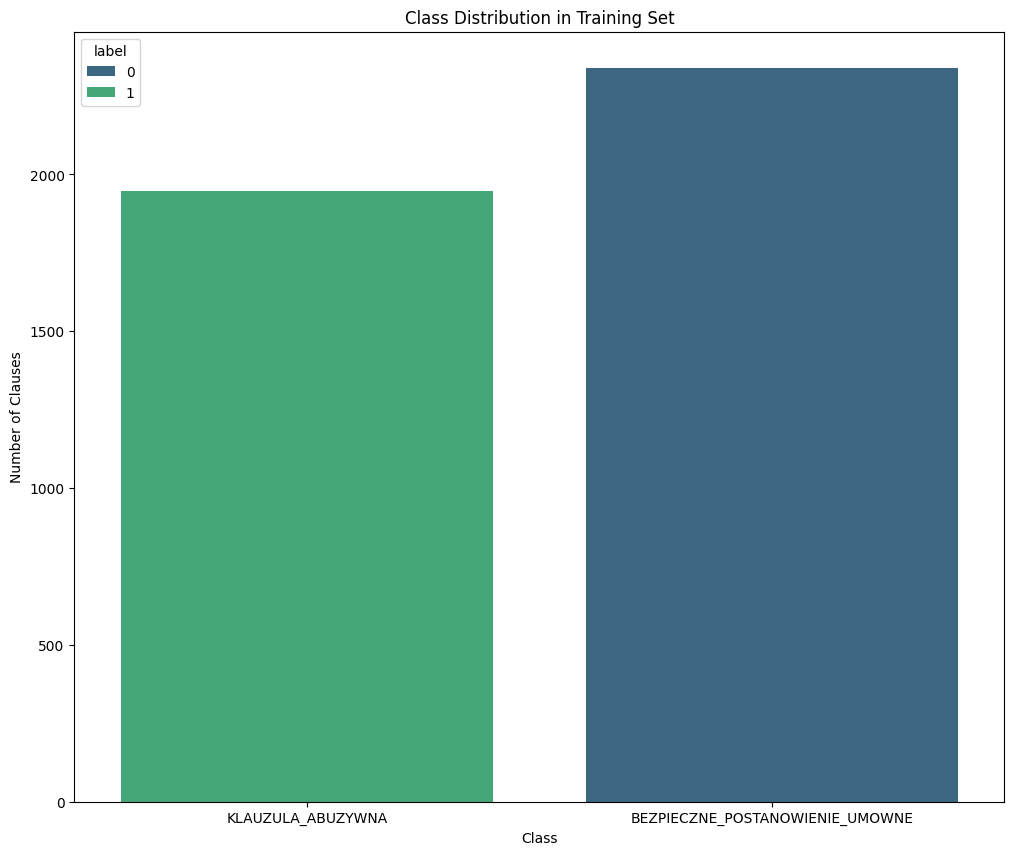

In [ ]:
plt.figure(figsize=(12, 10))
ax = sns.countplot(x='label_name', data=train_df, palette='viridis', hue='label', dodge=False)
plt.title('Class Distribution in Training Set')
plt.xlabel('Class')
plt.ylabel('Number of Clauses')

plt.show()

The datasets are balanced. However, when working with text, it is useful to compare sentence lengths in relation to their classes. In this case, the focus is on the number of words used (as approximation of the tokens).

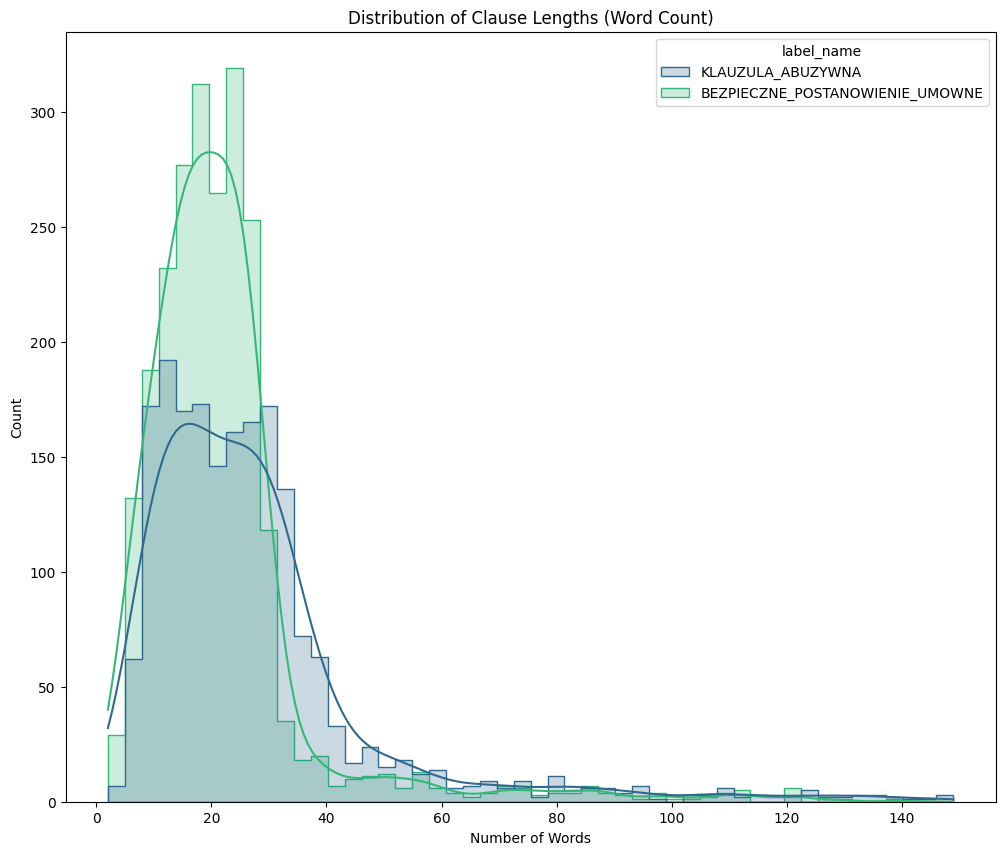

In [ ]:
train_df['word_count'] = train_df['text'].astype(str).apply(lambda x: len(x.split()))

plt.figure(figsize=(12, 10))
sns.histplot(data=train_df, x='word_count', hue='label_name', kde=True, palette='viridis', bins=50, element="step")

plt.title('Distribution of Clause Lengths (Word Count)')
plt.xlabel('Number of Words')
plt.ylabel('Count')
plt.show()

The datasets have a similar word count distribution. Abusive clauses are slightly longer on average and have a longer tail toward higher word counts.

Next, a ```clean_text``` column was added to the dataset, which corresponds to the cleaned text. All letters were converted to lowercase and punctuation marks were removed. Such operations allow for better results when using simpler models.

In [ ]:
def clean_text(data):
    data['text_lower'] = data['text'].str.lower()
    punct_pattern = f"[{re.escape(string.punctuation)}]"
    data['text_clean'] = data['text_lower'].str.replace(punct_pattern, ' ', regex=True)
    data['text_clean'] = data['text_clean'].str.split().str.join(' ')
    return data

train_df = clean_text(train_df)
val_df = clean_text(val_df)
test_df = clean_text(test_df)

### Unique values
The number of unique word occurrences was also checked, and the number of _effective_ words, defined as those appearing more than five times in the dataset, was calculated. These calculations can be useful when determining the number of parameters considered by the model.

In [ ]:
count_vec = CountVectorizer()
count_vec.fit(train_df['text_clean'].astype(str))
total_vocab = len(count_vec.vocabulary_)

count_vec_effective = CountVectorizer(min_df=5)
count_vec_effective.fit(train_df['text_clean'].astype(str))
effective_vocab = len(count_vec_effective.vocabulary_)

print(f"Total Unique Words: {total_vocab}")
print(f"Effective Words: {effective_vocab}")

Total Unique Words: 10750
Effective Words: 2950


## Simple models

### Logistic regression 2D
The ```cleaned datasets``` can then be tested on simpler models. The first is **TF-IDF** with logistic regression. The model was trained using various parameters, including checking different stop-word lists (none, basic, and more extensive). The model was optimized for the F1 score on the validation set.

The model that achieved the highest score was saved. For visualization purposes, in this step, the matrixes was reduced to two dimensions using **cosine metrics**.

For the best parameters, the F1 score was verified on the test set.

=== BEST PARAMS ===
Stopwords: None
Params: {'max_features': 500, 'min_dist': 0.1, 'n_neighbors': 30, 'ngram': (1, 2)}
Valid F1: 0.5965


F1 score: 0.6361


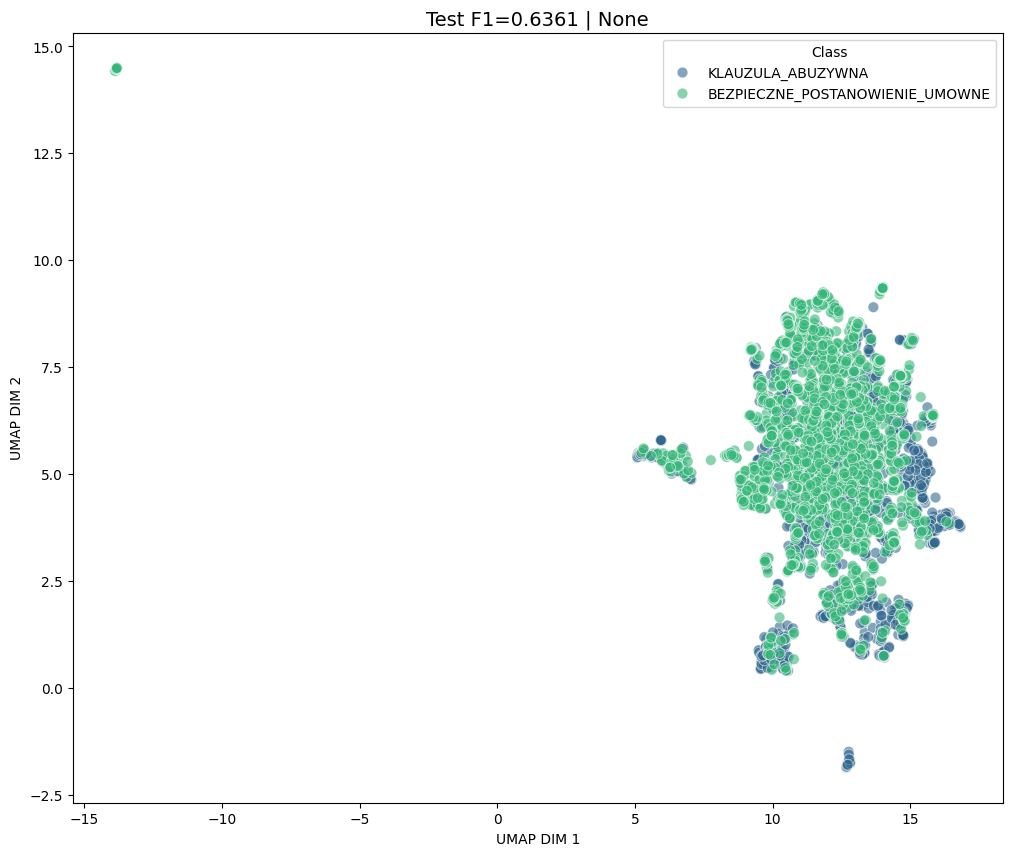

In [ ]:
warnings.filterwarnings('ignore')

stop_words_basic = ["i", "w", "na", "a", "oraz", "lub", "ale", "że", "to", "że", "się", "z", "został", "być", "jest", "był", "była", "było", "iż", "dla", "do", "od", "po", "przez", "w", "we", "wśród", "za", "ze", "czy", "albo", "ani", "więc", "toteż", "także"]
stop_words_extended = stop_words_basic + ["ach", "aj", "albo", "bardzo", "bez", "bo", "bowiem", "by", "byli", "bym", "była", "było", "były", "będzie", "będą", "cali", "cała", "cały", "ci",
                                          "ciebie", "cię", "co", "cokolwiek", "coś", "czasami", "czasem", "czemu", "czy", "czyli", "daleko", "dla", "dlaczego", "dlatego", "do", "dobrze",
                                          "dokąd", "dość", "dużo", "dwa", "dwaj", "dwie", "dwoje", "dziś", "dzisiaj", "gdy", "gdyby", "gdyż", "gdzie", "gdziekolwiek", "gdzieś", "go", "i",
                                          "ich", "ile", "im", "inna", "inne", "inny", "innych", "iż", "ja", "jak", "jakieś", "jakże", "je", "jeden", "jedna", "jedno", "jednak", "jeśli", "jeżeli",
                                          "już", "ją", "każdy", "kiedy", "kierunku", "kto", "ku", "lub", "ma", "mają", "mam", "mamy", "mało", "me", "mnie", "mną", "mogą", "moi", "moim", "mojemu",
                                          "może", "możliwe", "można", "mój", "mu", "musi", "my", "na", "nad", "nam", "nami", "nas", "nasi", "nasz", "nasza", "nasze", "naszego", "naszych", "natomiast",
                                          "nawet", "nic", "nich", "nie", "nigdy", "nim", "niż", "no", "o", "obok", "od", "około", "on", "ona", "one", "oni", "ono", "owszem", "pan", "pani", "po", "pod", 
                                          "podczas", "pomimo", "ponad", "ponieważ", "powinien", "powinna", "powinni", "powinno", "poza", "przed", "przede", "przez", "przy", "roku", "również", "sam", "sama", 
                                          "są", "się", "skąd", "sobie", "sobą", "sposób", "swoje", "ta", "tak", "taka", "taki", "takie", "także", "tam", "te", "tego", "tej", "temu", "ten", "teraz", "też", "to", 
                                          "tobie", "tobą", "toteż", "totobą", "trzeba", "tu", "tutaj", "twoja", "twoje", "twój", "ty", "tych", "tylko", "tym", "u", "w", "wam", "wami", "was", "wasz", "wasza", "wasze", "we", "według", 
                                          "wiele", "wielu", "więc", "więcej", "wszyscy", "wszystkich", "wszystkie", "wszystkim", "wszystko", "wtedy", "wy", "właśnie", "z", "za", "zawsze", "ze", "zł", "znowu", "znów", "został", "żaden", 
                                          "żadna", "żadne", "żadnych", "że", "żeby"]
stop_word_variants = {
    'None': None,
    'basic': stop_words_basic,
    'extended': stop_words_extended
}

param_grid = {
    'max_features': [500, int(effective_vocab // 2 + 0.025 * effective_vocab), int(effective_vocab + 0.05 * effective_vocab)],
    'ngram': [(1,1), (1,2)],
    'n_neighbors': [15, 30, 50],
    'min_dist': [0.1, 0.5]
}

grid = list(ParameterGrid(param_grid))

best_val_score = -1
best_params = {}
best_sw_name = ""

best_model_tfidf = None
best_model_umap = None
best_model_clf = None
best_embedding_train = None

for sw_name, sw_list in stop_word_variants.items():
    for params in grid:
        try:
            tfidf = TfidfVectorizer(
                max_features=params['max_features'], 
                ngram_range=params['ngram'],
                min_df=5, 
                max_df=0.5, 
                stop_words=sw_list
            )
            X_train_vec = tfidf.fit_transform(train_df['text_clean'].astype(str))
            X_val_vec = tfidf.transform(val_df['text_clean'].astype(str))

            reducer = umap.UMAP(
                n_neighbors=params['n_neighbors'],
                min_dist=params['min_dist'],
                metric='cosine', 
                random_state=42, 
            )
            embedding_train = reducer.fit_transform(X_train_vec)
            embedding_val = reducer.transform(X_val_vec)

            clf = LogisticRegression(solver='liblinear', random_state=42)
            clf.fit(embedding_train, train_df['label'])

            y_pred_val = clf.predict(embedding_val)
            current_f1 = f1_score(val_df['label'], y_pred_val, average='macro')


            if current_f1 > best_val_score:
                best_val_score = current_f1
                best_params = params
                best_sw_name = sw_name
                
                best_model_tfidf = tfidf
                best_model_umap = reducer
                best_model_clf = clf
                best_embedding_train = embedding_train

        except Exception as e:
            print(f"Error with {params}: {e}")
            continue

print("=== BEST PARAMS ===")
print(f"Stopwords: {best_sw_name}")
print(f"Params: {best_params}")
print(f"Valid F1: {best_val_score:.4f}")

X_test_vec = best_model_tfidf.transform(test_df['text_clean'].astype(str))
embedding_test = best_model_umap.transform(X_test_vec)
y_pred_test = best_model_clf.predict(embedding_test)
final_test_f1 = f1_score(test_df['label'], y_pred_test,  average='macro')

print(f"\n\nF1 score: {final_test_f1:.4f}")


plt.figure(figsize=(12, 10))
sns.scatterplot(
    x=best_embedding_train[:, 0], 
    y=best_embedding_train[:, 1], 
    hue=train_df['label_name'], 
    palette='viridis', 
    alpha=0.6,
    s=60
)
plt.title(f"Test F1={final_test_f1:.4f} | {best_sw_name}", fontsize=14)
plt.xlabel('UMAP DIM 1')
plt.ylabel('UMAP DIM 2')
plt.legend(title='Class')
plt.show()

The obtained F1 score of 0.52 is insufficient. The resulting plot shows that the classes almost completely overlap. This likely results from the dimensionality reduction of the dataset. Reducing a vector of several thousand parameters to only two could have caused a significant loss of information, including key features. In legal datasets, even small simplifications can determine whether a clause is legal or illegal. For this reason, lemmatization and stemming were also not used.

### Logistic regression

To test this theory, the training was repeated, focusing on a higher score rather than ease of visualization. The resulting matrices were not reduced. 

A brief parameter optimization was performed again, this time using a cross-validation mechanism. The F1 score was then checked for the best model.

In [ ]:
X_train = train_df['text_clean']
y_train = train_df['label']

X_test = test_df['text_clean']
y_test = test_df['label']

pipeline_baseline = Pipeline([
    ('tfidf', TfidfVectorizer(max_features=5000, ngram_range=(1,2), stop_words=stop_words_basic)),
    ('clf', LogisticRegression(class_weight='balanced', max_iter=1000))
])

params_baseline = {
    'tfidf__stop_words': [None, stop_words_basic, stop_words_extended],
    'tfidf__max_features': [500, int(effective_vocab // 2 + 0.05 *0.1 * effective_vocab), int(effective_vocab + 0.1 * effective_vocab)],
    'tfidf__ngram_range': [(1,1), (1,2), (1,3)],
    'tfidf__min_df': [2, 5, 10],

    'clf__C': [0.1, 1, 10],
    'clf__class_weight': ['balanced', None],
}

grid_search = GridSearchCV(pipeline_baseline, params_baseline, cv=3, scoring='f1', verbose=1)
grid_search.fit(X_train, y_train)

print("=== BEST PARAMS ===")
print(grid_search.best_params_)
best_model = grid_search.best_estimator_

y_pred = best_model.predict(X_test)
score = f1_score(y_test, y_pred, average='macro')
print("\n \n Macro F1 Score on Test Set: ", score)

Fitting 3 folds for each of 486 candidates, totalling 1458 fits
=== BEST PARAMS ===
{'clf__C': 10, 'clf__class_weight': 'balanced', 'tfidf__max_features': 3245, 'tfidf__min_df': 2, 'tfidf__ngram_range': (1, 1), 'tfidf__stop_words': ['i', 'w', 'na', 'a', 'oraz', 'lub', 'ale', 'że', 'to', 'że', 'się', 'z', 'został', 'być', 'jest', 'był', 'była', 'było', 'iż', 'dla', 'do', 'od', 'po', 'przez', 'w', 'we', 'wśród', 'za', 'ze', 'czy', 'albo', 'ani', 'więc', 'toteż', 'także']}

 
 Macro F1 Score on Test Set:  0.7745766755437195


The obtained F1 score in this case is much higher and amounts to 0.78. This is a very good result, which shows that a large part of the results is likely dependent on specific words specific words used in the illegal clauses.

Due to the simplicity of the model used, it is possible to extract the _decisive_ words.

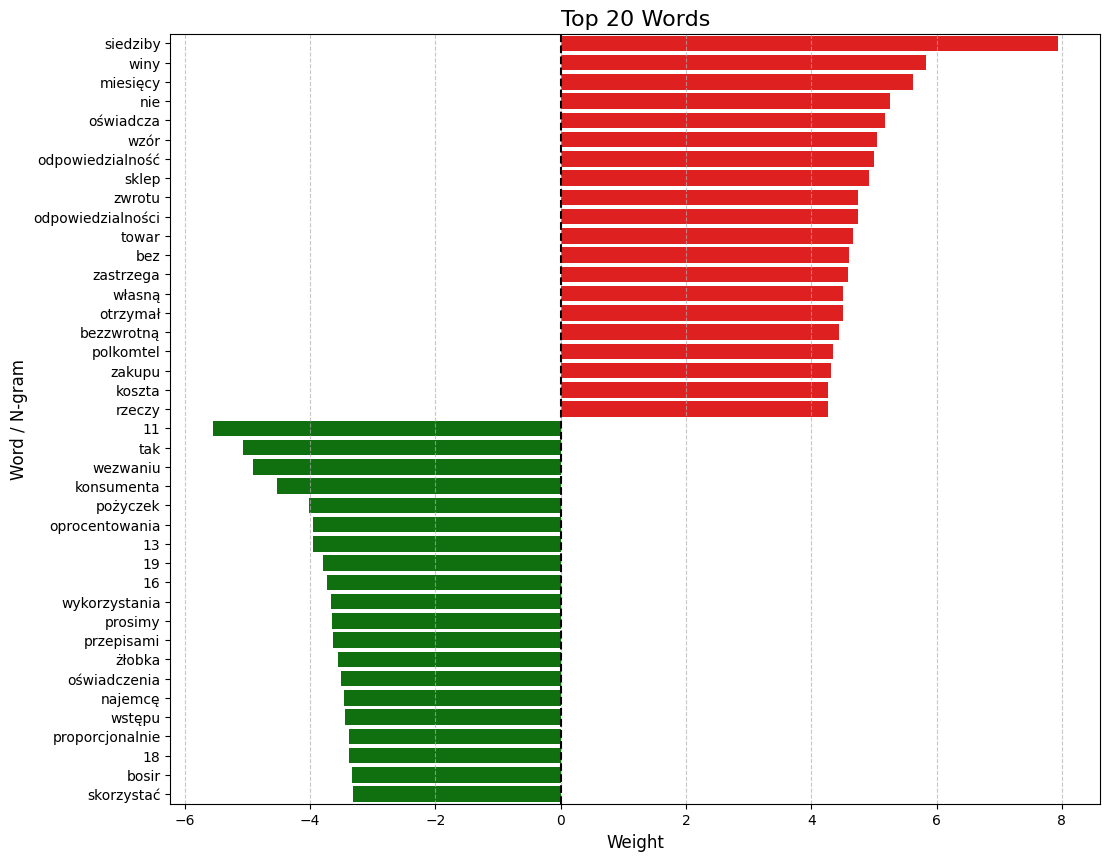

In [ ]:
feature_names = best_model.named_steps['tfidf'].get_feature_names_out()
coefficients = best_model.named_steps['clf'].coef_[0]

feature_importance = pd.DataFrame({
    'Word': feature_names,
    'Coefficient': coefficients
})

top_abusive = feature_importance.sort_values(by='Coefficient', ascending=False).head(20)
top_safe = feature_importance.sort_values(by='Coefficient', ascending=True).head(20)
top_features = pd.concat([top_abusive, top_safe])


colors = ['red' if x > 0 else 'green' for x in top_features['Coefficient']]

plt.figure(figsize=(12, 10))
sns.barplot(
    x='Coefficient', 
    y='Word', 
    data=top_features,
    palette=colors
)

plt.title('Top 20 Words', fontsize=16)
plt.xlabel('Weight', fontsize=12)
plt.ylabel('Word / N-gram', fontsize=12)
plt.axvline(x=0, color='black', linestyle='--')
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()

The words analysis reveals certain patterns learned by the model.

A safe classification is strongly associated with legal precision and procedural compliance. This is represented by the presence of high-weight numbers, which likely correspond to specific legal articles. Polite language, such as the word prosimy, is also a positive sign for the model. Additionally, banking terminology, such as oprocentowania or bank, is considered safe.

The abusive side is dominated by words related to arbitrariness and negation. Terms that limit consumer options, like nie, bez, and bezzwrotna, are considered unsafe. The same applies to terms that attempt to transfer risk to the consumer, such as winy or odpowiedzialność.

An interesting phenomenon is the detection of a specific entity name, BOSiR, as a predictor of safe clauses. This highlights the specific nature of the training dataset, which is based on UOKiK decisions regarding particular large enterprises. This is a characteristic of this specific dataset rather than a general rule.

### LDA (Topic Modeling)
Given these observations, where **banking terminology** and **BOSiR** are marked as safe while typical **e-commerce** words are marked as abusive, it may be useful to separate the clauses by topic. 

This could be a very effective approach for this dataset. A quick optimization of the model hyperparameters will be performed again to find best model for topic separation.

Fitting 3 folds for each of 12 candidates, totalling 36 fits


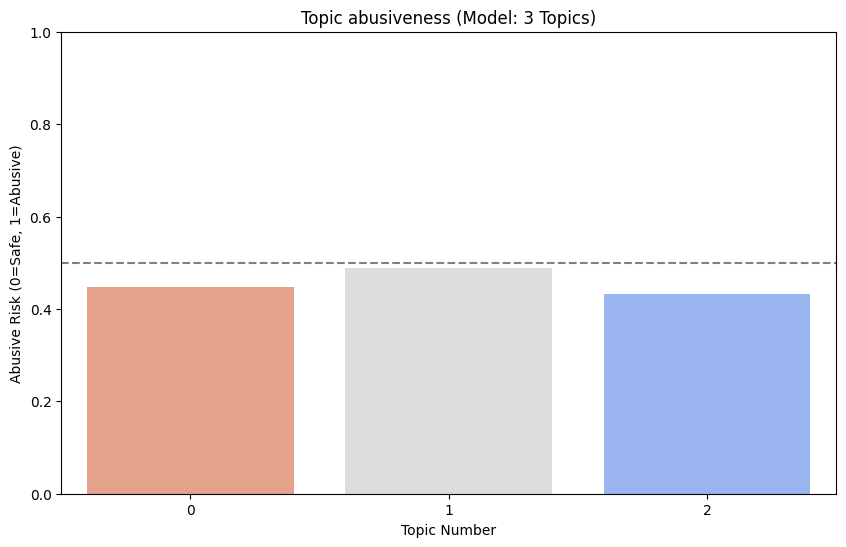

Topic 0 | Ratio: 0.45 | MIXED
   Words: zł, umowy, zmiany, sobie, prawo, zastrzega, bank, nie, będą, wszelkie 

Topic 1 | Ratio: 0.49 | MIXED
   Words: nie, kredytu, ponosi, odpowiedzialności, może, pożyczki, odpowiedzialność, szkoły, mogą, bez 

Topic 2 | Ratio: 0.43 | MIXED
   Words: umowy, przypadku, nie, dni, może, ust, terminie, dnia, będzie, wysokości 



In [ ]:
vectorizer = CountVectorizer(
    max_features=3000, 
    min_df=5, 
    stop_words=stop_words_basic
)

data_vectorized = vectorizer.fit_transform(train_df['text_clean'].astype(str))

search_params = {
    'n_components': [3, 5, 7, 10], 
    'learning_decay': [0.5, 0.7, 0.9]
}

lda = LatentDirichletAllocation(
    max_iter=10, 
    learning_method='online', 
    random_state=42,
)

model = GridSearchCV(lda, param_grid=search_params, cv=3, verbose=1)
model.fit(data_vectorized)
best_lda_model = model.best_estimator_

lda_output = best_lda_model.transform(data_vectorized)
train_df['topic'] = lda_output.argmax(axis=1)

topic_stats = train_df.groupby('topic')['label'].agg(['count', 'mean']).reset_index()
topic_stats.columns = ['Topic', 'Count', 'Abusive_Ratio']


plt.figure(figsize=(10, 6))
sns.barplot(x='Topic', y='Abusive_Ratio', data=topic_stats, palette='coolwarm_r') 
plt.title(f'Topic abusiveness (Model: {model.best_params_["n_components"]} Topics)')
plt.ylabel('Abusive Risk (0=Safe, 1=Abusive)')
plt.xlabel('Topic Number')
plt.axhline(y=0.5, color='gray', linestyle='--')
plt.ylim(0, 1)
plt.show()

feature_names = vectorizer.get_feature_names_out()

for topic_idx, topic in enumerate(best_lda_model.components_):
    top_words = [feature_names[i] for i in topic.argsort()[:-11:-1]]
    ratio = topic_stats.iloc[topic_idx]['Abusive_Ratio']

    if ratio > 0.65: status = " ABUSIVE"
    elif ratio < 0.35: status = "SAFE"
    else: status = "MIXED"
    
    print(f"Topic {topic_idx} | Ratio: {ratio:.2f} | {status}")
    print(f"   Words: {', '.join(top_words)} \n")

The results clearly show that dividing the dataset by topic did not lead to class separation. All topics score around 0.45 to 0.5. This suggests that the boundary between safe and abusive clauses is subtle and exists within the same thematic areas, such as payment regulations or liability. This is a strong argument for the necessity of using supervised learning methods.

## Deep Learning Models

### RoBERTa-v2
The next step was to evaluate how **deep learning models** handle the dataset. This marks a shift from focusing on keywords (Logistic Regression) to understanding context.

Based on the [KLEJ Benchmark](https://klejbenchmark.com/leaderboard/) ranking, the following models were selected:
- Polish RoBERTa-v2 (large)
- Polish RoBERTa-v2 (base)

The models have the highest scores in polish language for large and basic model. For text tokenization ```AutoTokenizer``` from transformer library was used.

In [4]:
def tokenize_function(examples):
    return tokenizer(
        examples["text"],
        padding="max_length",
        truncation=True,
        max_length=256
    )

MODEL = "sdadas/polish-roberta-base-v2"
tokenizer = AutoTokenizer.from_pretrained(MODEL)
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

tokenized_train = train_ds.map(tokenize_function, batched=True)
tokenized_val = val_ds.map(tokenize_function, batched=True)
tokenized_test = test_ds.map(tokenize_function, batched=True)

The **Optuna** library was used for model optimization to automatically run tests and select the best parameters.

Due to the high computational cost of large model, the hyperparameter tuning process was performed on a lighter Base model. 

The optimal learning hyperameters determined this way, such as learning rate and number of epochs, were used to narrow down the search space for the large model.

Due to the size of the large model, the optimization algorithm was changed to ```Adafactor```, at it allows to save significant amount of VRAM.

In [5]:
optuna.logging.set_verbosity(optuna.logging.WARNING)
transformers.logging.set_verbosity_error()

def model_init():
    return AutoModelForSequenceClassification.from_pretrained(
        MODEL, 
        num_labels=2,
        return_dict=True
        )

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = logits.argmax(axis=-1)
    f1 = f1_score(labels, predictions, average='macro')
    acc_score = accuracy_score(labels, predictions)
    return {'f1': f1, 'accuracy': acc_score}

def hp_space(trial):
    return {
        'learning_rate': trial.suggest_float('learning_rate', 1e-5, 4e-5, log=True),
        'per_device_train_batch_size': trial.suggest_categorical('per_device_train_batch_size', [16, 32]),
        'num_train_epochs': trial.suggest_int('num_train_epochs', 3, 5),
        'weight_decay': trial.suggest_float('weight_decay', 0.01, 0.1),
        'warmup_ratio': trial.suggest_float('warmup_ratio', 0.0, 0.1, step=0.05)
    }

training_args = TrainingArguments(
    output_dir="./basic_results_optuna",
    eval_strategy="epoch",
    save_strategy="no",
    logging_strategy="no",

    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    weight_decay=0.01,
    load_best_model_at_end=False,
    metric_for_best_model="f1",

    optim="adafactor",

    report_to="none",
    disable_tqdm=True,
    fp16=True
)

trainer = Trainer(
    model_init=model_init,
    args=training_args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_val,
    data_collator=data_collator,
    compute_metrics=compute_metrics
)

best_run = trainer.hyperparameter_search(
    direction="maximize",
    hp_space=hp_space,
    backend ="optuna",
    n_trials=20
)

print("\n\n=== BEST HYPERPARAMS ===")
print(f"{best_run.hyperparameters}\n\n")

for n,v in best_run.hyperparameters.items():
    setattr(trainer.args, n, v)

trainer.args.save_strategy = "epoch"
trainer.args.load_best_model_at_end = True
trainer.args.output_dir = "./final_model_base_optuna"
trainer.args.disable_tqdm = False

trainer.model = model_init()
trainer.train()

test_results = trainer.predict(tokenized_test)
print ("\n\n=== TEST SET RESULTS ===")
print(f"{test_results.metrics}\n\n")

trainer.save_model("./best_model_base_optuna")
tokenizer.save_pretrained("./best_model_base_optuna")

Loading weights: 100%|██████████| 197/197 [00:00<00:00, 1610.34it/s, Materializing param=roberta.encoder.layer.11.output.dense.weight]              


{'eval_loss': '0.6367', 'eval_f1': '0.5849', 'eval_accuracy': '0.6708', 'eval_runtime': '1.969', 'eval_samples_per_second': '771.3', 'eval_steps_per_second': '48.24', 'epoch': '1'}
{'eval_loss': '0.6235', 'eval_f1': '0.6588', 'eval_accuracy': '0.7149', 'eval_runtime': '1.964', 'eval_samples_per_second': '773.4', 'eval_steps_per_second': '48.37', 'epoch': '2'}
{'eval_loss': '0.6706', 'eval_f1': '0.6718', 'eval_accuracy': '0.736', 'eval_runtime': '2.026', 'eval_samples_per_second': '749.8', 'eval_steps_per_second': '46.89', 'epoch': '3'}
{'train_runtime': '80.88', 'train_samples_per_second': '158.9', 'train_steps_per_second': '9.941', 'train_loss': '0.2917', 'epoch': '3'}


Loading weights: 100%|██████████| 197/197 [00:00<00:00, 1661.67it/s, Materializing param=roberta.encoder.layer.11.output.dense.weight]              


{'eval_loss': '0.6072', 'eval_f1': '0.5852', 'eval_accuracy': '0.682', 'eval_runtime': '1.96', 'eval_samples_per_second': '774.9', 'eval_steps_per_second': '48.46', 'epoch': '1'}
{'eval_loss': '0.6133', 'eval_f1': '0.6615', 'eval_accuracy': '0.7222', 'eval_runtime': '1.965', 'eval_samples_per_second': '772.9', 'eval_steps_per_second': '48.34', 'epoch': '2'}
{'eval_loss': '0.6145', 'eval_f1': '0.6616', 'eval_accuracy': '0.7176', 'eval_runtime': '2.073', 'eval_samples_per_second': '732.8', 'eval_steps_per_second': '45.83', 'epoch': '3'}
{'eval_loss': '0.732', 'eval_f1': '0.6787', 'eval_accuracy': '0.7406', 'eval_runtime': '2.035', 'eval_samples_per_second': '746.3', 'eval_steps_per_second': '46.67', 'epoch': '4'}
{'eval_loss': '0.7822', 'eval_f1': '0.6828', 'eval_accuracy': '0.7373', 'eval_runtime': '1.986', 'eval_samples_per_second': '764.9', 'eval_steps_per_second': '47.84', 'epoch': '5'}
{'train_runtime': '115.3', 'train_samples_per_second': '185.7', 'train_steps_per_second': '5.809',

Loading weights: 100%|██████████| 197/197 [00:00<00:00, 1702.96it/s, Materializing param=roberta.encoder.layer.11.output.dense.weight]              


{'eval_loss': '0.6356', 'eval_f1': '0.5871', 'eval_accuracy': '0.6728', 'eval_runtime': '1.932', 'eval_samples_per_second': '786.1', 'eval_steps_per_second': '49.16', 'epoch': '1'}
{'eval_loss': '0.6362', 'eval_f1': '0.6646', 'eval_accuracy': '0.7242', 'eval_runtime': '1.927', 'eval_samples_per_second': '788.2', 'eval_steps_per_second': '49.3', 'epoch': '2'}
{'eval_loss': '0.6686', 'eval_f1': '0.6807', 'eval_accuracy': '0.734', 'eval_runtime': '1.942', 'eval_samples_per_second': '782.3', 'eval_steps_per_second': '48.93', 'epoch': '3'}
{'train_runtime': '79.05', 'train_samples_per_second': '162.6', 'train_steps_per_second': '10.17', 'train_loss': '0.2837', 'epoch': '3'}


Loading weights: 100%|██████████| 197/197 [00:00<00:00, 1674.85it/s, Materializing param=roberta.encoder.layer.11.output.dense.weight]              


{'eval_loss': '0.6348', 'eval_f1': '0.5225', 'eval_accuracy': '0.7011', 'eval_runtime': '1.935', 'eval_samples_per_second': '785.1', 'eval_steps_per_second': '49.1', 'epoch': '1'}
{'eval_loss': '0.648', 'eval_f1': '0.6641', 'eval_accuracy': '0.7215', 'eval_runtime': '1.927', 'eval_samples_per_second': '788.1', 'eval_steps_per_second': '49.29', 'epoch': '2'}
{'eval_loss': '0.7065', 'eval_f1': '0.6725', 'eval_accuracy': '0.7413', 'eval_runtime': '1.937', 'eval_samples_per_second': '784.2', 'eval_steps_per_second': '49.05', 'epoch': '3'}
{'train_runtime': '67.06', 'train_samples_per_second': '191.7', 'train_steps_per_second': '5.995', 'train_loss': '0.2732', 'epoch': '3'}


Loading weights: 100%|██████████| 197/197 [00:00<00:00, 1764.03it/s, Materializing param=roberta.encoder.layer.11.output.dense.weight]              


{'eval_loss': '0.5799', 'eval_f1': '0.5779', 'eval_accuracy': '0.7024', 'eval_runtime': '1.937', 'eval_samples_per_second': '784.2', 'eval_steps_per_second': '49.05', 'epoch': '1'}
{'eval_loss': '0.6223', 'eval_f1': '0.6625', 'eval_accuracy': '0.7222', 'eval_runtime': '1.938', 'eval_samples_per_second': '783.6', 'eval_steps_per_second': '49.01', 'epoch': '2'}
{'eval_loss': '0.6859', 'eval_f1': '0.6786', 'eval_accuracy': '0.7426', 'eval_runtime': '1.938', 'eval_samples_per_second': '783.9', 'eval_steps_per_second': '49.03', 'epoch': '3'}
{'train_runtime': '67.26', 'train_samples_per_second': '191.1', 'train_steps_per_second': '5.977', 'train_loss': '0.2658', 'epoch': '3'}


Loading weights: 100%|██████████| 197/197 [00:00<00:00, 1672.08it/s, Materializing param=roberta.encoder.layer.11.output.dense.weight]              


{'eval_loss': '0.7481', 'eval_f1': '0.5893', 'eval_accuracy': '0.6359', 'eval_runtime': '1.913', 'eval_samples_per_second': '794.2', 'eval_steps_per_second': '49.67', 'epoch': '1'}


Loading weights: 100%|██████████| 197/197 [00:00<00:00, 1718.32it/s, Materializing param=roberta.encoder.layer.11.output.dense.weight]              


{'eval_loss': '0.6111', 'eval_f1': '0.5813', 'eval_accuracy': '0.6853', 'eval_runtime': '1.928', 'eval_samples_per_second': '787.9', 'eval_steps_per_second': '49.28', 'epoch': '1'}


Loading weights: 100%|██████████| 197/197 [00:00<00:00, 1636.53it/s, Materializing param=roberta.encoder.layer.11.output.dense.weight]              


{'eval_loss': '0.6942', 'eval_f1': '0.5835', 'eval_accuracy': '0.6682', 'eval_runtime': '1.95', 'eval_samples_per_second': '779', 'eval_steps_per_second': '48.72', 'epoch': '1'}


Loading weights: 100%|██████████| 197/197 [00:00<00:00, 1634.39it/s, Materializing param=roberta.encoder.layer.11.output.dense.weight]              


{'eval_loss': '0.5931', 'eval_f1': '0.5649', 'eval_accuracy': '0.7018', 'eval_runtime': '1.952', 'eval_samples_per_second': '778.3', 'eval_steps_per_second': '48.67', 'epoch': '1'}


Loading weights: 100%|██████████| 197/197 [00:00<00:00, 1610.46it/s, Materializing param=roberta.encoder.layer.11.output.dense.weight]              


{'eval_loss': '0.6353', 'eval_f1': '0.6035', 'eval_accuracy': '0.6662', 'eval_runtime': '1.938', 'eval_samples_per_second': '783.7', 'eval_steps_per_second': '49.02', 'epoch': '1'}
{'eval_loss': '0.6265', 'eval_f1': '0.6323', 'eval_accuracy': '0.7005', 'eval_runtime': '1.938', 'eval_samples_per_second': '783.7', 'eval_steps_per_second': '49.01', 'epoch': '2'}


Loading weights: 100%|██████████| 197/197 [00:00<00:00, 1551.53it/s, Materializing param=roberta.encoder.layer.11.output.dense.weight]              


{'eval_loss': '0.6048', 'eval_f1': '0.5585', 'eval_accuracy': '0.6932', 'eval_runtime': '1.947', 'eval_samples_per_second': '780.1', 'eval_steps_per_second': '48.79', 'epoch': '1'}


Loading weights: 100%|██████████| 197/197 [00:00<00:00, 1655.85it/s, Materializing param=roberta.encoder.layer.11.output.dense.weight]              


{'eval_loss': '0.6132', 'eval_f1': '0.5369', 'eval_accuracy': '0.6952', 'eval_runtime': '1.935', 'eval_samples_per_second': '785.1', 'eval_steps_per_second': '49.1', 'epoch': '1'}


Loading weights: 100%|██████████| 197/197 [00:00<00:00, 1637.56it/s, Materializing param=roberta.encoder.layer.11.output.dense.weight]              


{'eval_loss': '0.632', 'eval_f1': '0.621', 'eval_accuracy': '0.6761', 'eval_runtime': '1.934', 'eval_samples_per_second': '785.5', 'eval_steps_per_second': '49.13', 'epoch': '1'}
{'eval_loss': '0.6447', 'eval_f1': '0.6266', 'eval_accuracy': '0.6906', 'eval_runtime': '1.925', 'eval_samples_per_second': '789', 'eval_steps_per_second': '49.35', 'epoch': '2'}


Loading weights: 100%|██████████| 197/197 [00:00<00:00, 1601.74it/s, Materializing param=roberta.encoder.layer.11.output.dense.weight]              


{'eval_loss': '0.6304', 'eval_f1': '0.5782', 'eval_accuracy': '0.6794', 'eval_runtime': '1.948', 'eval_samples_per_second': '779.6', 'eval_steps_per_second': '48.76', 'epoch': '1'}


Loading weights: 100%|██████████| 197/197 [00:00<00:00, 1729.14it/s, Materializing param=roberta.encoder.layer.11.output.dense.weight]              


{'eval_loss': '0.5951', 'eval_f1': '0.5727', 'eval_accuracy': '0.688', 'eval_runtime': '1.945', 'eval_samples_per_second': '781.1', 'eval_steps_per_second': '48.85', 'epoch': '1'}


Loading weights: 100%|██████████| 197/197 [00:00<00:00, 1620.57it/s, Materializing param=roberta.encoder.layer.11.output.dense.weight]              


{'eval_loss': '0.5979', 'eval_f1': '0.5567', 'eval_accuracy': '0.6959', 'eval_runtime': '1.939', 'eval_samples_per_second': '783.4', 'eval_steps_per_second': '49', 'epoch': '1'}


Loading weights: 100%|██████████| 197/197 [00:00<00:00, 1515.52it/s, Materializing param=roberta.encoder.layer.11.output.dense.weight]              


{'eval_loss': '0.6221', 'eval_f1': '0.598', 'eval_accuracy': '0.6873', 'eval_runtime': '1.946', 'eval_samples_per_second': '780.7', 'eval_steps_per_second': '48.83', 'epoch': '1'}
{'eval_loss': '0.6799', 'eval_f1': '0.637', 'eval_accuracy': '0.6814', 'eval_runtime': '1.935', 'eval_samples_per_second': '784.9', 'eval_steps_per_second': '49.09', 'epoch': '2'}


Loading weights: 100%|██████████| 197/197 [00:00<00:00, 1769.27it/s, Materializing param=roberta.encoder.layer.11.output.dense.weight]              


{'eval_loss': '0.6578', 'eval_f1': '0.583', 'eval_accuracy': '0.6564', 'eval_runtime': '1.942', 'eval_samples_per_second': '782.3', 'eval_steps_per_second': '48.93', 'epoch': '1'}


Loading weights: 100%|██████████| 197/197 [00:00<00:00, 1745.64it/s, Materializing param=roberta.encoder.layer.11.output.dense.weight]              


{'eval_loss': '0.6247', 'eval_f1': '0.5898', 'eval_accuracy': '0.688', 'eval_runtime': '1.939', 'eval_samples_per_second': '783.3', 'eval_steps_per_second': '48.99', 'epoch': '1'}
{'eval_loss': '0.6173', 'eval_f1': '0.6561', 'eval_accuracy': '0.7202', 'eval_runtime': '1.942', 'eval_samples_per_second': '782', 'eval_steps_per_second': '48.91', 'epoch': '2'}


Loading weights: 100%|██████████| 197/197 [00:00<00:00, 1672.42it/s, Materializing param=roberta.encoder.layer.11.output.dense.weight]              


{'eval_loss': '0.6084', 'eval_f1': '0.5919', 'eval_accuracy': '0.6906', 'eval_runtime': '1.923', 'eval_samples_per_second': '789.9', 'eval_steps_per_second': '49.4', 'epoch': '1'}
{'eval_loss': '0.6517', 'eval_f1': '0.6502', 'eval_accuracy': '0.6991', 'eval_runtime': '1.925', 'eval_samples_per_second': '789.1', 'eval_steps_per_second': '49.35', 'epoch': '2'}


=== BEST HYPERPARAMS ===
{'learning_rate': 3.3937123824636685e-05, 'per_device_train_batch_size': 32, 'num_train_epochs': 3, 'weight_decay': 0.013599276959466219, 'warmup_ratio': 0.0}




Loading weights: 100%|██████████| 197/197 [00:00<00:00, 1584.50it/s, Materializing param=roberta.encoder.layer.11.output.dense.weight]              


{'eval_loss': '0.5804', 'eval_f1': '0.5522', 'eval_accuracy': '0.709', 'eval_runtime': '2.011', 'eval_samples_per_second': '755.5', 'eval_steps_per_second': '47.25', 'epoch': '1'}


Writing model shards: 100%|██████████| 1/1 [00:00<00:00,  1.80it/s]


{'eval_loss': '0.5797', 'eval_f1': '0.6815', 'eval_accuracy': '0.734', 'eval_runtime': '2.043', 'eval_samples_per_second': '743.6', 'eval_steps_per_second': '46.51', 'epoch': '2'}


Writing model shards: 100%|██████████| 1/1 [00:00<00:00,  2.01it/s]


{'eval_loss': '0.6913', 'eval_f1': '0.6728', 'eval_accuracy': '0.74', 'eval_runtime': '1.95', 'eval_samples_per_second': '778.8', 'eval_steps_per_second': '48.71', 'epoch': '3'}


Writing model shards: 100%|██████████| 1/1 [00:00<00:00,  1.88it/s]


{'train_runtime': '71.56', 'train_samples_per_second': '179.6', 'train_steps_per_second': '5.618', 'train_loss': '0.2713', 'epoch': '3'}


=== TEST SET RESULTS ===
{'test_loss': 0.29093053936958313, 'test_f1': 0.856784152830985, 'test_accuracy': 0.8722849695916595, 'test_runtime': 4.448, 'test_samples_per_second': 776.308, 'test_steps_per_second': 48.561}




Writing model shards: 100%|██████████| 1/1 [00:00<00:00,  1.99it/s]


('./best_model_base_optuna/tokenizer_config.json',
 './best_model_base_optuna/tokenizer.json')

Using of **Deep Learning** significantly increased the F1 score to the value of 0.86. This is an excellent result, showing that with optimization even lighter (base) architecture can effectively understand context and detect nuances in legal terminology.

The best parameters obtained were used as a baseline for traning the larger model. The parameters remained the same, with the following chagnes (due to larger size of the new model):
- The batch size was pernamently fixed to value of 32
- The learning rate was reduced by half, to ensure stability

First, the toknes for larger model were created

In [3]:
def tokenize_function_large(examples):
    return tokenizer_large(
        examples["text"],
        padding="max_length",
        truncation=True,
        max_length=256
    )

MODEL_LARGE = "sdadas/polish-roberta-large-v2"
tokenizer_large = AutoTokenizer.from_pretrained(MODEL_LARGE)
data_collator_large = DataCollatorWithPadding(tokenizer=tokenizer_large)

tokenized_train_large = train_ds.map(tokenize_function_large, batched=True)
tokenized_val_large = val_ds.map(tokenize_function_large, batched=True)
tokenized_test_large = test_ds.map(tokenize_function_large, batched=True)

Map: 100%|██████████| 3453/3453 [00:00<00:00, 20425.42 examples/s]


Next, the large model was trained. Optuna was used again, but this time the range for selecting parameters was significantly narrowed, as described above.

In [4]:
optuna.logging.set_verbosity(optuna.logging.WARNING)
transformers.logging.set_verbosity_error()

CENTER_LR = float(3.39e-5 / 2)
CENTER_WD = 0.014
CENTER_WARMUP = 0.05
BATCHSIZE = 32

PHYSICAL_BATCH_SIZE = 4
ACC_STEPS = BATCHSIZE // PHYSICAL_BATCH_SIZE

tokenizer_large = AutoTokenizer.from_pretrained(MODEL_LARGE)
data_collator_large = DataCollatorWithPadding(tokenizer=tokenizer_large)

def model_init_large():
    return AutoModelForSequenceClassification.from_pretrained(
        MODEL_LARGE, 
        num_labels=2,
        return_dict=True
        )

def compute_metrics_large(eval_pred):
    logits, labels = eval_pred
    predictions = logits.argmax(axis=-1)
    f1 = f1_score(labels, predictions, average='macro')
    acc_score = accuracy_score(labels, predictions)
    return {'f1': f1, 'accuracy': acc_score}

def hp_space(trial):
    return {
        'learning_rate': trial.suggest_float('learning_rate', CENTER_LR * 0.80, CENTER_LR * 1.20, log=True),
        'per_device_train_batch_size': PHYSICAL_BATCH_SIZE,
        'num_train_epochs': trial.suggest_int('num_train_epochs', 3, 5),
        'weight_decay': trial.suggest_float('weight_decay', CENTER_WD * 0.85, CENTER_WD * 1.15),
        'warmup_ratio': trial.suggest_float('warmup_ratio', max(0.0, CENTER_WARMUP * 0.85), min(0.1, CENTER_WARMUP * 1.15))
    }


training_args = TrainingArguments(
    output_dir="./large_results_optuna",
    eval_strategy="epoch",
    save_strategy="no",
    logging_strategy="no",

    per_device_train_batch_size=PHYSICAL_BATCH_SIZE,
    per_device_eval_batch_size=PHYSICAL_BATCH_SIZE,
    gradient_accumulation_steps=ACC_STEPS,
    gradient_checkpointing=True,

    optim="adafactor",

    learning_rate=CENTER_LR,
    num_train_epochs=4,
    weight_decay=CENTER_WD,
    load_best_model_at_end=False,
    metric_for_best_model="f1",

    report_to="none",
    disable_tqdm=True,
    fp16=True
)

trainer = Trainer(
    model_init=model_init_large,
    args=training_args,
    train_dataset=tokenized_train_large,
    eval_dataset=tokenized_val_large,
    data_collator=data_collator_large,
    compute_metrics=compute_metrics_large
)

best_run = trainer.hyperparameter_search(
    direction="maximize",
    hp_space=hp_space,
    backend ="optuna",
    n_trials=20
)

print("\n\n=== BEST HYPERPARAMS ===")
print(f"{best_run.hyperparameters}\n\n")

for n,v in best_run.hyperparameters.items():
    setattr(trainer.args, n, v)

trainer.args.save_strategy = "epoch"
trainer.args.load_best_model_at_end = True
trainer.args.output_dir = "./final_model_large_optuna"
trainer.args.disable_tqdm = False

trainer.model = model_init_large()
trainer.train()

test_results = trainer.predict(tokenized_test_large)
print ("\n\n=== TEST SET RESULTS ===")
print(f"{test_results.metrics}\n\n")

trainer.save_model("./best_model_large_optuna")
tokenizer_large.save_pretrained("./best_model_large_optuna")

{'eval_loss': 0.6054830551147461, 'eval_f1': 0.6787212907953031, 'eval_accuracy': 0.7050691244239631, 'eval_runtime': 7.1847, 'eval_samples_per_second': 211.422, 'eval_steps_per_second': 52.89, 'epoch': 0.9934640522875817}
{'eval_loss': 0.5250287652015686, 'eval_f1': 0.7040334692126153, 'eval_accuracy': 0.7656352863726136, 'eval_runtime': 7.1903, 'eval_samples_per_second': 211.256, 'eval_steps_per_second': 52.849, 'epoch': 1.9934640522875817}
{'eval_loss': 0.6612114310264587, 'eval_f1': 0.7072383786644982, 'eval_accuracy': 0.771560236998025, 'eval_runtime': 7.1997, 'eval_samples_per_second': 210.981, 'eval_steps_per_second': 52.78, 'epoch': 2.9934640522875817}
{'train_runtime': 329.6506, 'train_samples_per_second': 38.987, 'train_steps_per_second': 1.21, 'train_loss': 0.24512938688273417, 'epoch': 2.9934640522875817}
{'eval_loss': 0.6035774350166321, 'eval_f1': 0.6457390736508233, 'eval_accuracy': 0.67412771560237, 'eval_runtime': 7.2503, 'eval_samples_per_second': 209.508, 'eval_steps

('./best_model_large_optuna/tokenizer_config.json',
 './best_model_large_optuna/special_tokens_map.json',
 './best_model_large_optuna/tokenizer.json')

The obtained F1 score of 0.87 is the highest result achieved so far. It proves that a larger model is better at recognizing patterns within the clauses.

### Large Language Model (Bielik)
The final test was conducted using a large Polish language model, Bielik 11B.

In this case, there is no need to tokenize the entire dataset. The final test was conducted using Bielik 11B, a large Polish language model. Due to model's size, its weights were quantized.

In [7]:
MODEL_LLM = "speakleash/Bielik-11B-v2.3-Instruct"
SAMPLE_SIZE = 500

tokenizer_llm = AutoTokenizer.from_pretrained(MODEL_LLM, use_fast=True)
if tokenizer_llm.pad_token is None:
    tokenizer_llm.pad_token = tokenizer_llm.add_special_eos_token

train_abusive = train_ds.filter(lambda x: x['label'] == 1).shuffle(seed=42).select(range(5))
train_safe = train_ds.filter(lambda x: x['label'] == 0).shuffle(seed=42).select(range(5))

few_shots = ""

examples = []
for ex in train_abusive:
    examples.append(ex)

for ex in train_safe:
    examples.append(ex)

for ex in examples:
    few_shots += f"Klauzula: {ex['text']}\nWynik: {ex['label']}\n"

In the case of the large language model, a **few-shot prompting** technique was applied, providing 6 examples of both abusive and safe clauses within the instruction. The model was then asked to perform the classification. It was not fine-tuned in any way; instead, it had to assign the correct class based solely on the provided examples and its own _internal knowledge_.

In [8]:
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.float16
)

model_llm = AutoModelForCausalLM.from_pretrained(
    MODEL_LLM,
    quantization_config=bnb_config,
    device_map={"": 0},
    low_cpu_mem_usage=True,
    torch_dtype=torch.float16
)

model_llm.eval()

def generate_classification(text, few_shots):
    prompt = f"""<s>[INST] Sklasyfikuj podaną klauzulę umowną.
1 = klauzula niedozwolona (abuzywna)
0 = klauzula dozwolona (bezpieczna)

{few_shots}
Klauzula: "{text}"
Wynik (podaj tylko 0 lub 1): [/INST]"""

    inputs = tokenizer_llm(prompt, return_tensors="pt").to(model_llm.device)

    with torch.inference_mode():
        outputs = model_llm.generate(
            **inputs,
            max_new_tokens=2,
            do_sample=False,
            pad_token_id=tokenizer_llm.eos_token_id
        )

    response = tokenizer_llm.decode(outputs[0][inputs["input_ids"].shape[1]:], skip_special_tokens=True).strip()
    found = re.search(r'[01]', response)
    
    if found:
        return int(found.group())

    upper_resp = response.upper()
    if "ABU" in upper_resp:
        return 1
    if "BEZ" in upper_resp:
        return 0
        
    return -1


test_sample = test_ds.shuffle(seed=42).select(range(SAMPLE_SIZE))
true_labels = []
bielik_predictions = []

for record in tqdm(test_sample):
    clause_text = record['text']
    pred_label = generate_classification(clause_text, few_shots)
    if pred_label == 1 or pred_label == 0:
        bielik_predictions.append(pred_label)
        true_labels.append(record['label'])

print("\n\n=== BIELIK LLM CLASSIFICATION REPORT ===")
print (f"Correct answer format in {len(bielik_predictions)} out of {SAMPLE_SIZE} samples.")
print(classification_report(true_labels, bielik_predictions, digits=4))

100%|██████████| 500/500 [03:57<00:00,  2.11it/s]



=== BIELIK LLM CLASSIFICATION REPORT ===
Correct answer format in 480 out of 500 samples.
              precision    recall  f1-score   support

           0     0.7715    0.6603    0.7116       312
           1     0.5023    0.6369    0.5617       168

    accuracy                         0.6521       480
   macro avg     0.6369    0.6486    0.6366       480
weighted avg     0.6773    0.6521    0.6591       480



The F1 score of 0.64 obtained by the large language model clearly demonstrates that even a simpler model, when specifically trained for a particular task, can perform better. For comparison, Logistic Regression achieved a score of 0.78, while the deep learning-based RoBERTa models were able to push this result as high as 0.88.

This does not mean that the Bielik model is weak; it is designed for text generation and is not specialized in the specific task of identifying legal clauses. Futhermore, the permformance gap may be attributed to quantization, because identifying legal nuances often relies on extremly subtle inguistic cues.

## Final results
The obtaind results are presented as table below:

| Model | F1 score macro | Approx. Parameters |
| :--- | :---: | :---: |
| LR with dim reduction | 0.52| 500 |
| LR without dim reduction | 0.78| 3200 |
| Polish RoBERTa-v2 Basic | 0.86 | 125 Million |
| Polish RoBERTa-v2 Large | 0.87 | 355 Million |
| Bielik 11B v.23 | 0.66 | 11 Billion |


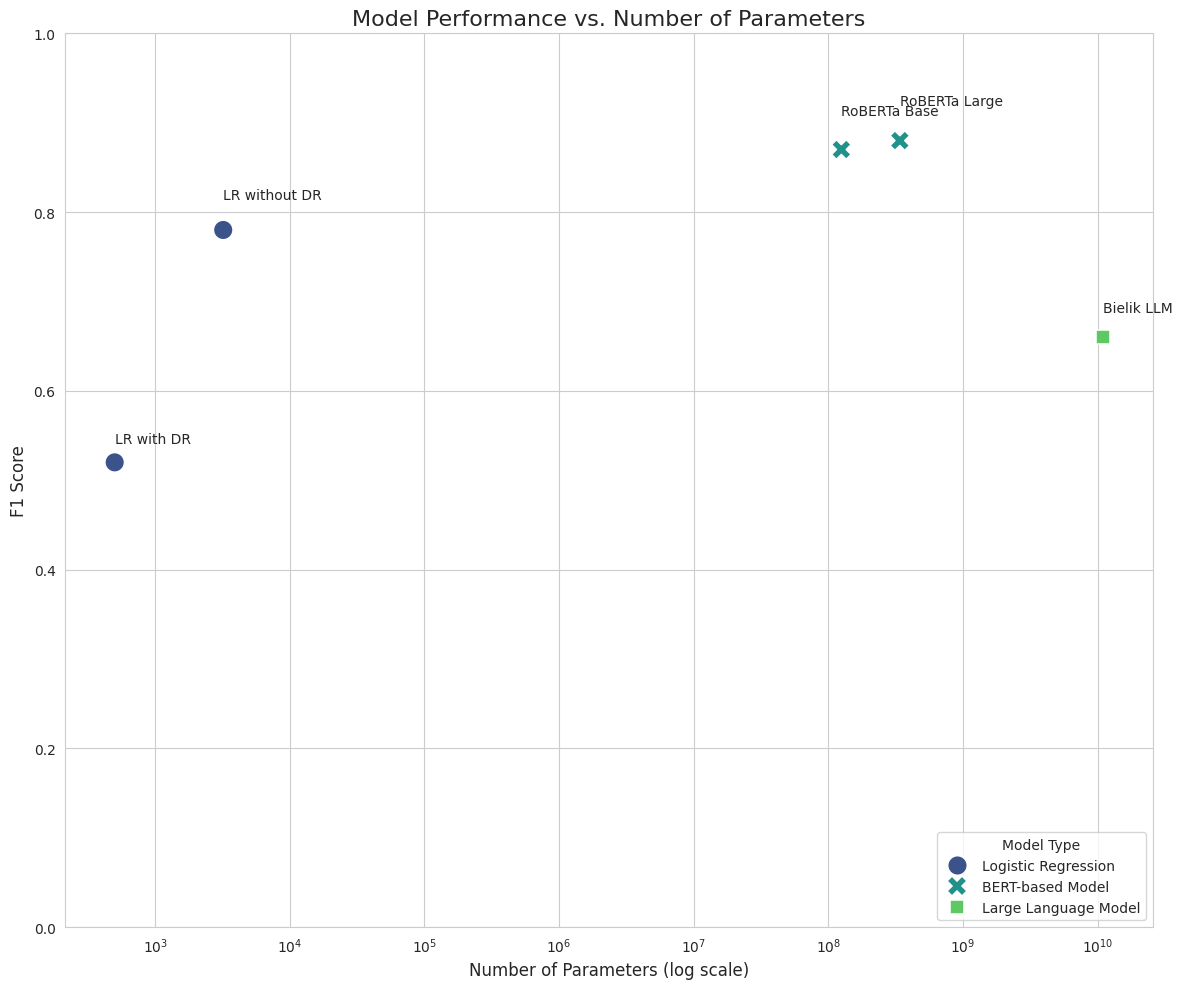

In [9]:
data = {
    'Model': [
        'LR with DR',
        'LR without DR',
        'RoBERTa Base',
        'RoBERTa Large',
        'Bielik LLM'
    ],
    'F1 Score': [
        0.52,
        0.78,
        0.87,
        0.88,
        0.66
    ],
    'Parameters': [
        500,
        3200,
        125e6,
        340e6,
        11e9
    ],
    'Type': [
        'Logistic Regression',
        'Logistic Regression',
        'BERT-based Model',
        'BERT-based Model',
        'Large Language Model'
    ]
}

result_df = pd.DataFrame(data)
plt.figure(figsize=(12, 10))
sns.set_style("whitegrid")

scatter = sns.scatterplot(
    data=result_df,
    x='Parameters',
    y='F1 Score',
    hue='Type',
    style='Type',
    s=200,
    palette='viridis',
    zorder=5
)

for i in range (result_df.shape[0]):
    plt.text(
        x=result_df['Parameters'][i],
        y=result_df['F1 Score'][i]* 1.05,
        s=result_df['Model'][i],
        fontsize=10,
        verticalalignment='center'
    )


plt.xscale('log')
plt.legend(loc = 'lower right', title='Model Type')
plt.title('Model Performance vs. Number of Parameters', fontsize=16)
plt.xlabel('Number of Parameters (log scale)', fontsize=12)
plt.ylabel('F1 Score', fontsize=12)
plt.ylim(0, 1)
plt.tight_layout()
plt.show()

The best results were achieved using the RoBERTa-v2 Large model, though RoBERTa-v2 Base also performed very well. Combining deep learning with task-specific training allowed for high F1 scores.

As part of the project, a thematic division using LDA was also attempted. However, this approach failed to clearly separate the individual classes, confirming that the distinction between safe and abusive clauses is more subtle than a simple difference in topic.